# Transformation from/to IR

$$
\newcommand{\iv}{{\mathrm{i}\nu}}
\newcommand{\wmax}{{\omega_\mathrm{max}}}
\newcommand{\dd}{{\mathrm{d}}}
$$

In this section, we explain how to transform numerical data to IR.

## Poles

We consider a Green's function genereated by poles:

$$
G(\iv) = \sum_{p=1}^{N_\mathrm{P}} \frac{c_p}{\iv - \omega_p},
$$

where $\nu$ is a fermionic or bosonic Matsubara frequency.
The corresponding specral function $A(\omega)$ is given by

$$
A(\omega) = \sum_{p=1}^{N_\mathrm{P}} c_p \delta(\omega - \omega_p).
$$

The modified (regularized) spectral function reads

$$
\rho(\omega) = 
\begin{cases}
\sum_{p=1}^{N_\mathrm{P}} c_p \delta(\omega - \omega_p) & \mathrm{(fermion)},\\
\sum_{p=1}^{N_\mathrm{P}} (c_p/\tanh(\beta \omega_p/2)) \delta(\omega - \omega_p) & \mathrm{(boson)}.
\end{cases}
$$

for the logistic kernel.
We immediately obtain

$$
\rho_l = 
\begin{cases}
\sum_{p=1}^{N_\mathrm{P}} c_p V_l(\omega_p) & \mathrm{(fermion)},\\
\sum_{p=1}^{N_\mathrm{P}} c_p V_l(\omega_p)/\tanh(\beta \omega_p/2))& \mathrm{(boson)}.
\end{cases}
$$

The following code demostrates this transformation for bosons.

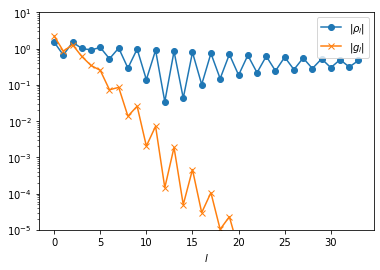

In [1]:
import sparse_ir
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

beta = 15
wmax = 10
basis_b = sparse_ir.FiniteTempBasis("B", beta, wmax, eps=1e-10)

coeff = np.array([1])
omega_p = np.array([0.1])

rhol_pole = np.einsum('lp,p->l', basis_b.v(omega_p), coeff/np.tanh(0.5*beta*omega_p))
gl_pole = - basis_b.s * rhol_pole

plt.semilogy(np.abs(rhol_pole), marker="o", label=r"$|\rho_l|$")
plt.semilogy(np.abs(gl_pole), marker="x", label=r"$|g_l|$")

plt.xlabel(r"$l$")
plt.ylim([1e-5, 1e+1])
plt.legend()
plt.show()

Alternatively, we can use ``spr`` (sparse pole presentation) module.

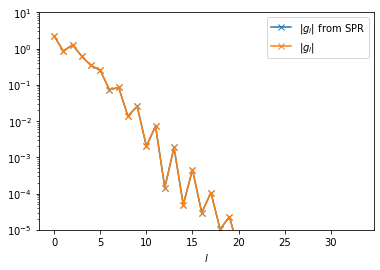

In [2]:
from sparse_ir.spr import SparsePoleRepresentation
sp = SparsePoleRepresentation(basis_b, omega_p)
gl_pole2 = sp.to_IR(coeff)

plt.semilogy(np.abs(gl_pole2), marker="x", label=r"$|g_l|$ from SPR")
plt.semilogy(np.abs(gl_pole), marker="x", label=r"$|g_l|$")


plt.xlabel(r"$l$")
plt.ylim([1e-5, 1e+1])
plt.legend()
plt.show()

## From smooth spectral function

For a smooth spectral function $\rho(\omega)$, the expansion coefficients can be evaluated by computing the integral

$$
\begin{align}
    \rho_l &= \int_{-\wmax}^\wmax \dd \omega V_l(\omega) \rho(\omega).
\end{align}
$$

One might consider to use the Gauss-Legendre quadrature.
As seen in previous sections, the distribution of $V_l(\omega)$ is much denser than Legendre polynomial $P_l(x(\tau))$ around $\tau=0, \beta$.
Thus, evaluating the integral precisely requires the use of composite Gauss–Legendre quadrature,
where the whole inteval $[-\wmax, \wmax]$ is divided to subintervals and the normal Gauss-Legendre quadrature is 
applied to each interval.
The roots of $V_l(\omega)$ for the highest $l$ used in the expansion
is a reasonable choice of the division points.
If $\rho(\omega)$ is smooth enough within each subinterval,
the result converges exponentially with increasing the degree of the Gauss-Legendre quadrature.

Below, we demonstrate how to compute $\rho_l$ for a spectral function consisting of of three Gausssian peaks using the composite Gauss-Legendre quadrature.
Then, $\rho_l$ can be transformed to $g_l$ by multiplying it with $- S_l$.

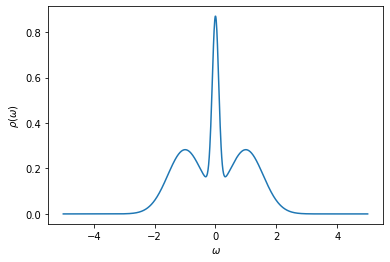

In [3]:
# Three Gaussian peaks (normalized to 1)
gaussian = lambda x, mu, sigma:\
    np.exp(-((x-mu)/sigma)**2)/(np.sqrt(np.pi)*sigma)

rho = lambda omega: 0.2*gaussian(omega, 0.0, 0.15) + \
    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

omegas = np.linspace(-5, 5, 1000)
plt.xlabel(r"$\omega$")
plt.ylabel(r"$\rho(\omega)$")
plt.plot(omegas, rho(omegas))
plt.show()

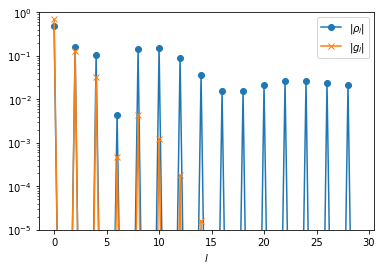

In [4]:
beta = 10
wmax = 10
basis = sparse_ir.FiniteTempBasis("F", beta, wmax, eps=1e-10)

rhol = basis.v.overlap(rho)
gl = - basis.s * rhol

plt.semilogy(np.abs(rhol), marker="o", label=r"$|\rho_l|$")
plt.semilogy(np.abs(gl), marker="x", label=r"$|g_l|$")
plt.xlabel(r"$l$")
plt.ylim([1e-5, 1])
plt.legend()
plt.show()

$\rho_l$ is evaluated on arbitrary real frequencies as follows.

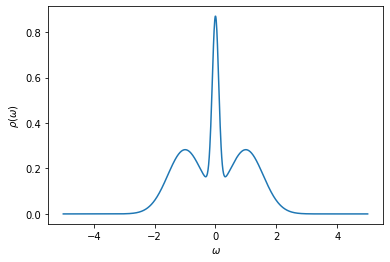

In [5]:
rho_omgea_reconst = basis.v(omegas).T @ rhol

plt.xlabel(r"$\omega$")
plt.ylabel(r"$\rho(\omega)$")
plt.plot(omegas, rho(omegas))
plt.show()

## From IR to imaginary time

We are now ready to evaluate $g_l$ on arbitrary $\tau$ points.
A naive way is as follows.

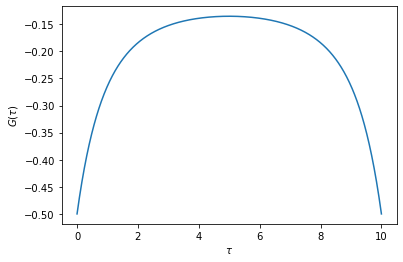

In [6]:
taus = np.linspace(0, beta, 1000)
gtau1 = basis.u(taus).T @ gl
plt.plot(taus, gtau1)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$G(\tau)$")
plt.show()

Alternatively, we can use ``TauSampling`` as follows.

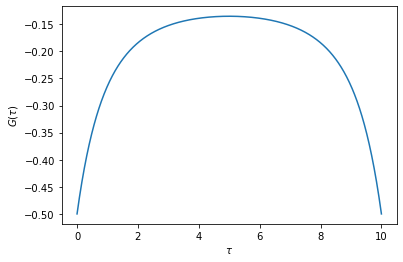

In [7]:
smpl = sparse_ir.TauSampling(basis, taus)
gtau2 = smpl.evaluate(gl)
plt.plot(taus, gtau1)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$G(\tau)$")
plt.show()

## From full imaginary-time data

A numerically stable way to expand $G(\tau)$ in IR 
is evaluating the integral

$$
G_l = \int_0^\beta \dd \tau G(\tau) U_l(\tau).
$$

You can use `overlap` function as well.

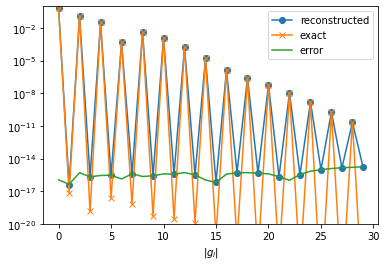

In [8]:
def eval_gtau(taus):
    uval = basis.u(taus) #(nl, ntau)
    return uval.T @ gl

gl_reconst = basis.u.overlap(eval_gtau)

plt.semilogy(np.abs(gl_reconst), label="reconstructed", marker="o")
plt.semilogy(np.abs(gl), label="exact", marker="x")
plt.semilogy(np.abs(gl_reconst - gl), label="error", marker="")
plt.xlabel(r"$l$")
plt.xlabel(r"$|g_l|$")
plt.ylim([1e-20, 1])
plt.legend()
plt.show()